In [1]:
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline
# import pdb

In [25]:
import os
import os.path as op
import argparse
from data.data_pipe import get_val_pair
from torchvision import transforms as trans
from tqdm import tqdm_notebook as tqdm
import torch
import numpy as np
from IPython.display import display

from Learner import face_learner
from config import get_config
from utils import hflip_batch, cosineDim1
from data.datasets import IJBCAllCroppedFacesDataset, IJBCVerificationPathDataset, ARVerificationAllPathDataset

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Init Learner and conf

In [14]:
conf = get_config(training=False)
conf.batch_size=20 # Why bs_size can only be the number that divide 6000 well?
learner = face_learner(conf, inference=True)

{'fixed_str': 'ir_se50.pth', 'pretrainedMdl': 'ir_se50.pth', 'data_path': PosixPath('data'), 'work_path': PosixPath('work_space'), 'model_path': PosixPath('work_space/models'), 'log_path': PosixPath('work_space/log'), 'save_path': PosixPath('work_space/save'), 'exp_title': 'xCos', 'exp_comment': 'expMS1M', 'input_size': [112, 112], 'embedding_size': 1568, 'use_mobilfacenet': False, 'net_depth': 50, 'drop_ratio': 0.6, 'net_mode': 'ir_se', 'device': device(type='cuda', index=0), 'test_transform': Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
), 'data_mode': 'emore', 'vgg_folder': PosixPath('data/faces_vgg_112x112'), 'ms1m_folder': PosixPath('data/faces_ms1m_112x112'), 'emore_folder': PosixPath('data/faces_emore'), 'batch_size': 20, 'USE_SOFTMAX': True, 'SOFTMAX_T': 1, 'facebank_path': PosixPath('data/facebank'), 'threshold': 1.5, 'threshold_xCos': 0.2338, 'face_limit': 10, 'min_face_size': 30}
ir_se_50 model generated


# Evaluate on ARFace

In [29]:
def l2normalize(x, ord=2, axis=None):
    return x / np.linalg.norm(x, ord=ord, axis=axis)


def score_fn_original(feat1, feat2):
    return l2normalize(feat1).dot(l2normalize(feat2))
    

def score_fn_ours(feat_map1, feat_map2, learner, attention_strategy='learned'):
    with torch.no_grad():
        assert len(feat_map1.shape) == 3  # [c, w, h]
        if attention_strategy == 'learned':
            attention = None
        elif attention_strategy == 'uniform':
            learner.model_attention.eval()
            attention = torch.ones([1, 1, feat_map1.shape[1], feat_map1.shape[2]])  # [batch, c, w, h]
            attention /= attention.sum()
            attention = attention.to(conf.device)
        else:
            raise NotImplementedError
        feat_map1 = torch.tensor(feat_map1).unsqueeze(0).to(conf.device)
        feat_map2 = torch.tensor(feat_map2).unsqueeze(0).to(conf.device)
        xCos, attention, cos_patched = learner.get_x_cosine(feat_map1, feat_map2, attention)
    return xCos.cpu().numpy()

In [21]:
from glob import glob
from copy import deepcopy
import random


class ARFaceSampler:
    def __init__(self, feat_root='./saved_features/ARFace/ir_se50_original/',
                 positive_num=6000, negative_num=6000,
                 conditions=('8', '9', '10', '11', '12', '13')):
        all_feature_files = sorted(glob(op.join(feat_root, '*.np*')))
        all_sample_names = [op.splitext(op.basename(f))[0] for f in all_feature_files]
        self.valid_sample_names = [n for n in all_sample_names if self._get_condition(n) in conditions]
        
        self.positive_pairs = self._build_pairs(num=positive_num, positive=True)
        self.negative_pairs = self._build_pairs(num=negative_num, positive=False)
        
    def _build_pairs(self, num, positive):
        # NOTE: this runs in O(n^2), but can be sped up
        pairs_left = random.choices(self.valid_sample_names, k=num)
        pairs_right = []
        for left in pairs_left:
            cid = self._get_candidate_id(left)
            available = [
                right
                for right in self.valid_sample_names
                if right != left and (self._get_candidate_id(left) == self._get_candidate_id(right)) == positive
            ]
            pairs_right.append(random.choice(available))
            
        pairs = [(left, right) for left, right in zip(pairs_left, pairs_right)]
        return pairs
            
    def _get_candidate_id(self, sample_name):
        return '-'.join(sample_name.split('-')[:2])
    
    def _get_condition(self, sample_name):
        return sample_name.split('-')[2]

In [22]:
ARFace_sampler = ARFaceSampler()

In [26]:
def evaluate_and_plot(scores, is_sames, nrof_folds=10):
    accuracy, best_threshold, roc_curve_tensor = learner.evaluate_and_plot_roc(scores, is_sames, nrof_folds=10)
    print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
    display(trans.ToPILImage()(roc_curve_tensor))

lfw - accuray:0.8550000000000001, threshold:0.2600000000000011


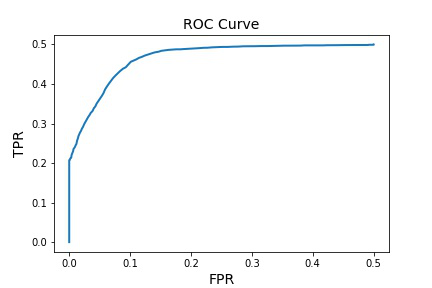

In [27]:
def _get_feature(feat_dir, suffix, ends_with='.npy'):
    return np.load(op.join(feat_dir, suffix) + ends_with)


feat_dir = './saved_features/ARFace/ir_se50_original/'
scores = []
for pair in ARFace_sampler.positive_pairs + ARFace_sampler.negative_pairs:
    p0_feat = _get_feature(feat_dir, pair[0]).squeeze(0)
    p1_feat = _get_feature(feat_dir, pair[1]).squeeze(0)
    scores.append(score_fn_original(p0_feat, p1_feat))
is_sames = np.array([True for _ in range(len(ARFace_sampler.positive_pairs))] +
                    [False for _ in range(len(ARFace_sampler.negative_pairs))])
scores = np.array(scores)
evaluate_and_plot(scores, is_sames, nrof_folds=10)

====== Evaluating on our model (2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace) ======
---- With attention ----
lfw - accuray:0.8360833333333334, threshold:0.16400000000000103


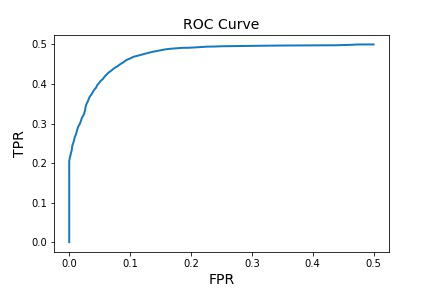

---- Without attention ----
lfw - accuray:0.8641666666666665, threshold:0.15900000000000106


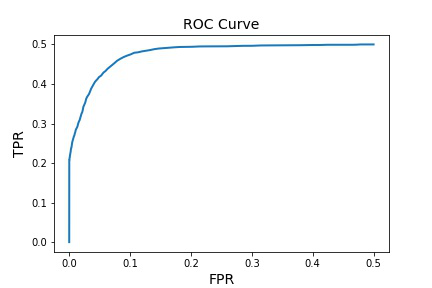


====== Evaluating on our model (2019-08-25-14-35_accuracy:0.9931666666666666_step:218349_None) ======
---- With attention ----
lfw - accuray:0.7253333333333334, threshold:0.168000000000001


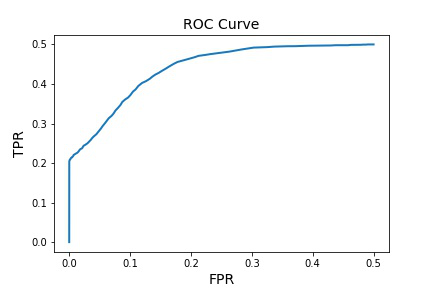

---- Without attention ----
lfw - accuray:0.787, threshold:0.1935000000000011


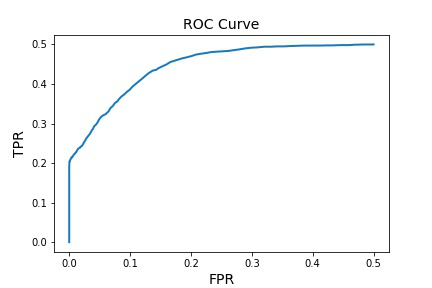


====== Evaluating on our model (2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None) ======
---- With attention ----
lfw - accuray:0.7800833333333335, threshold:0.19900000000000104


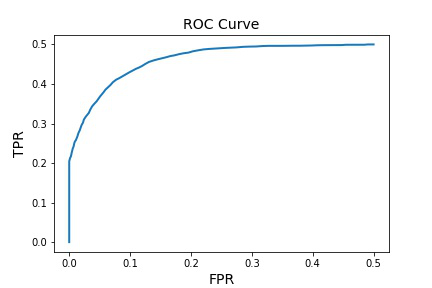

---- Without attention ----
lfw - accuray:0.8685, threshold:0.23000000000000115


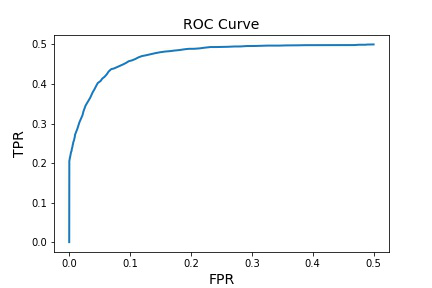


====== Evaluating on our model (2019-09-01-15-30_accuracy:0.9946666666666667_step:218346_CosFace) ======
---- With attention ----
lfw - accuray:0.7233333333333334, threshold:0.192000000000001


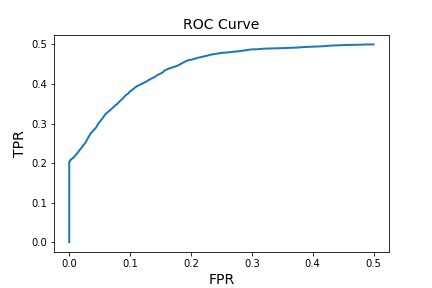

---- Without attention ----
lfw - accuray:0.7271666666666667, threshold:0.189500000000001


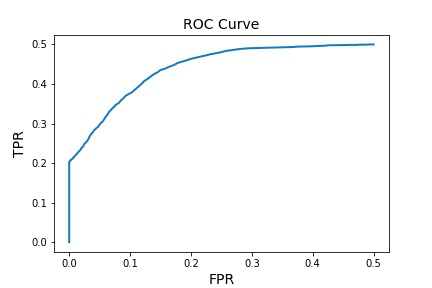

In [30]:
def evaluate_our_model_ARFace(model_name):
    def _get_feature(feat_dir, suffix, ends_with='.npz'):
        return np.load(op.join(feat_dir, suffix) + ends_with)


    feat_dir = f'./saved_features/ARFace/{model_name}/'
    scores = []
    scores_wo_attention = []
    for pair in ARFace_sampler.positive_pairs + ARFace_sampler.negative_pairs:
        p0_feat = _get_feature(feat_dir, pair[0])['feat_map'].squeeze(0)
        p1_feat = _get_feature(feat_dir, pair[1])['feat_map'].squeeze(0)
        scores.append(score_fn_ours(p0_feat, p1_feat, learner, attention_strategy='learned'))
        scores_wo_attention.append(score_fn_ours(p0_feat, p1_feat, learner, attention_strategy='uniform'))
    is_sames = np.array([True for _ in range(len(ARFace_sampler.positive_pairs))] +
                        [False for _ in range(len(ARFace_sampler.negative_pairs))])
    scores = np.array(scores).squeeze()
    scores_wo_attention = np.array(scores_wo_attention).squeeze()
    
    print('---- With attention ----')
    evaluate_and_plot(scores, is_sames, nrof_folds=10)
    
    print('---- Without attention ----')
    evaluate_and_plot(scores_wo_attention, is_sames, nrof_folds=10)
    
model_names = [
    '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace',
    '2019-08-25-14-35_accuracy:0.9931666666666666_step:218349_None',
    '2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None',
    '2019-09-01-15-30_accuracy:0.9946666666666667_step:218346_CosFace',
]
for model_name in model_names:
    print(f'====== Evaluating on our model ({model_name}) ======')
    evaluate_our_model_ARFace(model_name)
    print()

# Evaluate on IJB-C

In [2]:
loader = torch.utils.data.DataLoader(
    IJBCVerificationPathDataset('/tmp3/zhe2325138/IJB/IJB-C/', occlusion_lower_bound=0),
    batch_size=1, shuffle=True
)

In [3]:
def _get_feature(feat_dir, suffixes, ends_with='.npy'):
    return np.concatenate([
        np.load(op.join(feat_dir, suffix[0]) + ends_with)
        for suffix in suffixes
    ], axis=0)


feat_dir = './saved_features/IJB-C/ir_se50_original/'

compare_strategy = 'mean_comparison'
assert compare_strategy in ['exhausted_pairwise_comparison', 'mean_comparison']

is_sames = []
scores = []

for i, pair in enumerate(loader):
    if i == 1000: break
    enroll_features = _get_feature(feat_dir, pair['enroll_path_suffixes'])
    verif_features = _get_feature(feat_dir, pair['verif_path_suffixes'])
    is_sames.append(pair['is_same'].cpu().numpy().astype(np.bool))
    
    if compare_strategy == 'mean_comparison':
        enroll_faeture = enroll_features.mean(axis=0)
        verif_feature = verif_features.mean(axis=0)
        scores.append(score_fn_original(enroll_faeture, verif_feature))
    elif compare_strategy == 'exhausted_pairwise_comparison':
        raise NotImplementedError
    else:
        raise NotImplementedError

27190 27524
28464 28009


FileNotFoundError: [Errno 2] No such file or directory: './saved_features/IJB-C/ir_se50_original/img/28464_442443.jpg.npy'

# The following codes are just testing
## Evaluate on LFW (just testing)

In [31]:
def getUnitAttention():
    x = torch.ones(conf.batch_size//2, 1, 7, 7).cuda()
    x /= x.flatten(2).sum(dim=2).repeat(1, 1, x.size(2) * x.size(3)).view_as(x)
    return x
unit_attention = getUnitAttention()
unit_attention.size()

torch.Size([10, 1, 7, 7])

In [32]:
lfw, lfw_issame = get_val_pair(conf.emore_folder, 'lfw')
learner.load_state(conf, 'ir_se50.pth', model_only=True, from_save_folder=True, strict=False, model_atten=False)
learner.model.eval()
learner.model.returnGrid = True  # Remember to reset this before return!
learner.model_attention.eval()

AttentionXCosNet(
  (embedding_net): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (attention): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
  )
)

## Our models (wo/w attention)

lfw - accuray:0.9933333333333332, threshold:0.2600000000000011
CPU times: user 21min 22s, sys: 51.6 s, total: 22min 14s
Wall time: 1min 57s


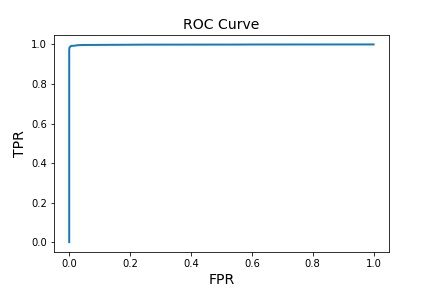

In [33]:
%%time
accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(
    conf, lfw, lfw_issame, nrof_folds=10, tta=True, attention=unit_attention
)
print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
trans.ToPILImage()(roc_curve_tensor)

In [ ]:
%%time
accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(
    conf, lfw, lfw_issame, nrof_folds=10, tta=True, attention=None
)
print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
trans.ToPILImage()(roc_curve_tensor)

## The original model

In [ ]:
%%time
cosines = learner.get_original_cosines(lfw, conf, tta=True)
accuracy, best_threshold, roc_curve_tensor = learner.evaluate_and_plot_roc(cosines, lfw_issame, nrof_folds=10)
print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
trans.ToPILImage()(roc_curve_tensor)

In [ ]:
corrPlot = learner.plot_CorrBtwXCosAndCos(conf, 
                                          lfw, lfw_issame, 
                                          nrof_folds=10, tta=True, 
                                          attention=unit_attention)
trans.ToPILImage()(corrPlot)